## 🔁 **Labor Mobility & Confidence**

*Tracks voluntary movement, layoffs, and temp labor demand*
**Frequency:** Monthly

| Indicator                                      | Source                |
| ---------------------------------------------- | --------------------- |
| Quit Rate                                      | JOLTS (`JTSQUR`)      |
| Layoffs and Discharges                         | JOLTS (`JTSLDL`)      |
| Total Separations                              | JOLTS (`JTSTSL`)      |
| Temporary Help Services Employment             | CES (`CES6054880001`) |

**Feature Engineering:**

* `QuitsToLayoffs = Quits / Layoffs`
* `VoluntaryExitRatio = Quits / Separations`
* `LayoffShock = % MoM change in Layoffs`
* `TempHelpMoM = % change in TEMPHELPS`
* `SeparationFlow_Z = z-score(Total Separations)`

---

In [4]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames
Quits_Rate_df = pd.read_csv('Quits_Rate.csv')
Layoffs_and_Discharges_df = pd.read_csv('Layoffs_and_Discharges.csv')
Total_Seperations_df = pd.read_csv('Total_Seperations.csv')
Temporary_Help_Services_Employment_df = pd.read_csv('Temporary_Help_Services_Employment.csv')




# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
Quits_Rate_df.to_sql('Quits', conn, index=False, if_exists='replace')
Layoffs_and_Discharges_df.to_sql('Layoffs', conn, index=False, if_exists='replace')
Total_Seperations_df.to_sql('Seperations', conn, index=False, if_exists='replace')
Temporary_Help_Services_Employment_df.to_sql('Temp_Help_Services_Employed', conn, index=False, if_exists='replace')



# SQL query to merge all tables on 'Player'
sql_query = """
SELECT 
    Quits.observation_date, 
    JTSQUL as "Quits",
    JTSLDL as "Layoffs",
    JTSTSL as "Seperations",
    TEMPHELPS as "Temp_Help_Services_Employed"
FROM Quits
INNER JOIN Layoffs ON Quits.observation_date = Layoffs.observation_date
INNER JOIN Seperations ON Quits.observation_date = Seperations.observation_date
INNER JOIN Temp_Help_Services_Employed ON Quits.observation_date = Temp_Help_Services_Employed.observation_date

"""


# Execute the query and load results into a DataFrame
Labor_Mobility_Confidence_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user


Labor_Mobility_Confidence_df

,observation_date,Quits,Layoffs,Seperations,Temp_Help_Services_Employed
0,2000-12-01,2882,2018,5240,2587.2
1,2001-01-01,3245,2220,5842,2566.4
2,2001-02-01,3053,1855,5231,2533.7
3,2001-03-01,3054,2133,5566,2485.3
4,2001-04-01,3163,1883,5414,2402.1
...,...,...,...,...,...
287,2024-11-01,3032,1739,5087,2550.1
288,2024-12-01,3095,1669,5082,2551.8
289,2025-01-01,3256,1674,5272,2543.8
290,2025-02-01,3250,1780,5316,2541.6


**Feature Engineering:**

* `QuitsToLayoffs = Quits / Layoffs`
* `VoluntaryExitRatio = Quits / Separations`
* `LayoffShock = % MoM change in Layoffs`
* `TempHelpMoM = % change in TEMPHELPS`
* `SeparationFlow_Z = z-score(Total Separations)`


In [5]:
from scipy.stats import zscore

Labor_Mobility_Confidence_df['Quits_to_Layoffs_Ratio'] = Labor_Mobility_Confidence_df['Quits'] - Labor_Mobility_Confidence_df['Layoffs']
Labor_Mobility_Confidence_df['Voluntary_Exit_Ratio'] = Labor_Mobility_Confidence_df['Quits'] - Labor_Mobility_Confidence_df['Seperations']
Labor_Mobility_Confidence_df['Layoff_Shock'] = Labor_Mobility_Confidence_df['Layoffs'].pct_change() * 100
Labor_Mobility_Confidence_df['Temp_Help_Pct_change'] = Labor_Mobility_Confidence_df['Temp_Help_Services_Employed'].pct_change() * 100
Labor_Mobility_Confidence_df['Seperation_Flow_ZScore'] = zscore(Labor_Mobility_Confidence_df['Seperations'])
Labor_Mobility_Confidence_df.columns

Index(['observation_date', 'Quits', 'Layoffs', 'Seperations',
       'Temp_Help_Services_Employed', 'Quits_to_Layoffs_Ratio',
       'Voluntary_Exit_Ratio', 'Layoff_Shock', 'Temp_Help_Pct_change',
       'Seperation_Flow_ZScore'],
      dtype='object')

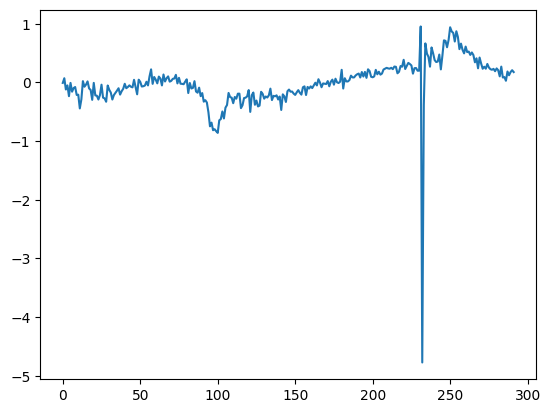

In [13]:
from scipy.stats import zscore


Labor_Mobility_Confidence_df['QuitsToLayoffs_z'] = zscore(Labor_Mobility_Confidence_df['Quits_to_Layoffs_Ratio'], nan_policy='omit')
Labor_Mobility_Confidence_df['VoluntaryExitRatio_z'] = zscore(Labor_Mobility_Confidence_df['Voluntary_Exit_Ratio'], nan_policy='omit')
Labor_Mobility_Confidence_df['LayoffShock_z'] = zscore(Labor_Mobility_Confidence_df['Layoff_Shock'], nan_policy='omit')
Labor_Mobility_Confidence_df['TempHelpMoM_z'] = zscore(Labor_Mobility_Confidence_df['Temp_Help_Pct_change'], nan_policy='omit')


Labor_Mobility_Confidence_df['Labor_Market_Mobility_Confidence_Index'] = Labor_Mobility_Confidence_df[[
    'QuitsToLayoffs_z',
    'VoluntaryExitRatio_z',
    'LayoffShock_z',
    'TempHelpMoM_z',
    'SeparationFlow_Z'
]].mean(axis=1, skipna=True)


Labor_Mobility_Confidence_df['Labor_Market_Mobility_Confidence_Index'].plot()


import os

# --- Labor Market Mobility & Confidence Index ---
os.makedirs('LMC', exist_ok=True)

Labor_Mobility_Confidence_df[['observation_date', 'Labor_Market_Mobility_Confidence_Index']].to_csv(
    'Labor_Market_Mobility_Confidence_Index.csv', index=False
)

import pandas as pd

# Load the Mobility Confidence Index data
mobility_df = pd.read_csv('Labor_Market_Mobility_Confidence_Index.csv')
mobility_df['observation_date'] = pd.to_datetime(mobility_df['observation_date'])

# Automatically assign labels based on quantiles
mobility_df['Mobility_Label'] = pd.qcut(
    mobility_df['Labor_Market_Mobility_Confidence_Index'],
    q=4,
    labels=['Stuck_Workforce', 'Hesitent_Movement', 'Stable_Confidence', 'Confident_Workers']
)

# Overwrite the original file with labels included
mobility_df.to_csv('Labor_Market_Mobility_Confidence_Index.csv', index=False)

